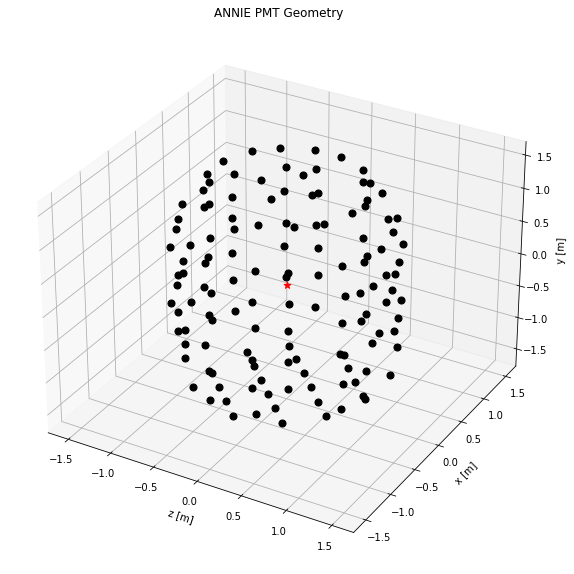

PMT Geometry Loaded

done


In [1]:
############################################################################
# Welcome to my Event Display for WCSim Simulated Events in the ANNIE Tank #
# ------------------------------------------------------------------------ #
#    The Event Display shows the tank PMT's response to simulated events   #
#  events from WCSim. The Timing and Hit information extracted from WCSim  #
#              are displayed in 2D and 3D Event Display Plots.             #
#  The simulated detector response of each ANNIEEvent is first put through #
#  the BeamClusterMC Toolchain in Toolanalysis, which produces Tree-level  #
#   information. Within the ToolChain, clusterization of the hits filters  # 
#   events based on their spacings in time, using the ClusterFinder and    #
#   ClusterClassifier Tools. These tools can be configured with varying    #
#      time intervals, but commonly they are used with 100ns spacings.     #
# Thus the hits we observe in this event display are the "clustered" hits, #
#   i.e. hits within some designated window of time. The event-level and   #
#  hit-level information is extracted from the ROOT Tree files and dumped  #
#             into .dat files which are read in by this code.              #
#    MC Truth information is also loaded in about the primary particle.    #    
# ------------------------------------------------------------------------ #
#                                 TLDR:                                    #
#  Event Display of the PMT response to WCSim simulated, clustered Events  #
# ------------------------------------------------------------------------ #
#                         Author: Steven Doran                             #
#                  Last Date of Modification: 3/15/23                      #
############################################################################

import numpy as np
import matplotlib.pyplot as plt
import pandas
#%matplotlib    # if you want to view the tank geometry in 3D, uncomment

### First, Load and Construct the Detector Geometry ###

# Read Geometry.csv file to get PMT location info
df = pandas.read_csv('FullTankPMTGeometry.csv')

channel_number = []; location = []; panel_number = []
x_position = []; y_position = []; z_position = []

# The LoadGeometry File does not share the same origin point as the WCSim output after ToolAnalysis.
# Need to adjust to ensure the (0,0,0) point (center of the tank) is the same.
# This offset is confirmed by plotting it without adjustments (see below, commented)

# vertical center (y) is at a height of y = -14.46 cm
# x-axis is fine
# z-axis (beamline) is offset by 1.681 m
# tank center is at (0,-14.46, 168.1) [cm]

for i in range(len(df['channel_num'])):   # loop over PMTs
    channel_number.append(df['channel_num'][i])
    location.append(df['detector_tank_location'][i])
    x_position.append(df['x_pos'][i]+0)
    y_position.append(df['y_pos'][i]+0.1446)
    z_position.append(df['z_pos'][i]-1.681)
    panel_number.append(df['panel_number'][i])
    

# # # # # # # # # # # # # # # # #
#  Displaying the Tank Geometry #
# # # # # # # # # # # # # # # # #
#%matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection='3d', computed_zorder=False)   # zorder was not manual as of 3.5.0

# Plot each PMT location
for i in range(len(channel_number)):
    ax.scatter(z_position[i], x_position[i], y_position[i], s = 50, color = 'black', zorder = 5)

# Plot detector center  (also a good check to see if the center in LoadGeometry was correctly formatted)
ax.scatter(0,0,0, s = 50, color = 'red', marker = '*', zorder = 1)

ax.set_aspect('auto')
ax.set_xlabel('z [m]')   # re-adjust the axes, to reflect the real-life geometry of the tank
ax.set_ylabel('x [m]')   # for example, y is really the height dimension of the ANNIE tank,
ax.set_zlabel('y [m]')   # but if you plotted it normally with a RH axes, it would show tank on its side

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([max(z_position)-min(z_position), max(x_position)-min(x_position), max(y_position)-min(y_position)]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(max(z_position)+min(z_position))
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(max(x_position)+min(x_position))
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(max(y_position)+min(y_position))
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

plt.title('ANNIE PMT Geometry')
plt.show()

print('PMT Geometry Loaded')
print('\ndone')

### Event Display

In [2]:
#################################################################################
# For each clustered event (just referred to as cluster from now on), load in the 
# event-level information (like charge balance, number of hits, etc..)

# # # # # # # # # # # # # # # 
# Parameterization -- load in the .dat files
position = 'center'
folder = 'Extracted_Data/'
path_charge = folder + 'charge_event_' + position + '.dat'
# # # # # # # # # # # # # # #

event_header = np.loadtxt(path_charge, dtype = str, delimiter = None, max_rows = 1)
event_data = np.loadtxt(path_charge, dtype = float, delimiter = None, skiprows = 1)

clustereventNumber = event_data.T[0]
clusterCharge = event_data.T[1]
clusterPE = event_data.T[2]
clusterMaxPE = event_data.T[3]
clusterChargeBalance = event_data.T[4]
clusterHits = event_data.T[5]

N_events = len(clustereventNumber)

# Now load in the hits-level information
path_hits = folder + 'cluster_hits_' + position + '.dat'
hits_header = np.loadtxt(path_hits, dtype = str, delimiter = None, max_rows = 1)
hits_data = np.loadtxt(path_hits, dtype = float, delimiter = None, skiprows = 1)

Channel = [[] for i in range(N_events)]
hitT = [[] for i in range(N_events)]      # The x,y,z is adjusted correctly in the ToolChain for this Event Display
hitX = [[] for i in range(N_events)]
hitY = [[] for i in range(N_events)]
hitZ = [[] for i in range(N_events)]
hitQ = [[] for i in range(N_events)]
hitPE = [[] for i in range(N_events)]

count = 0
for j in range(len(hits_data.T[0])):    # loop over all hits (N events x M hits per event)
    if (j == 0):
        Channel[count].append(hits_data.T[1][j])
        hitT[count].append(hits_data.T[2][j])      # the hitX, hitY, hitZ contain the position of the
        hitX[count].append(hits_data.T[3][j])      # PMTs that were hit
        hitY[count].append(hits_data.T[4][j])      
        hitZ[count].append(hits_data.T[5][j])
        hitQ[count].append(hits_data.T[6][j])
        hitPE[count].append(hits_data.T[7][j])
        
    elif (j != 0):
        if hits_data.T[0][j] == hits_data.T[0][j-1]:
            Channel[count].append(hits_data.T[1][j])
            hitT[count].append(hits_data.T[2][j])
            hitX[count].append(hits_data.T[3][j])
            hitY[count].append(hits_data.T[4][j])
            hitZ[count].append(hits_data.T[5][j])
            hitQ[count].append(hits_data.T[6][j])
            hitPE[count].append(hits_data.T[7][j])
        else:
            count = count + 1
            Channel[count].append(hits_data.T[1][j])
            hitT[count].append(hits_data.T[2][j])
            hitX[count].append(hits_data.T[3][j])
            hitY[count].append(hits_data.T[4][j])
            hitZ[count].append(hits_data.T[5][j])
            hitQ[count].append(hits_data.T[6][j])
            hitPE[count].append(hits_data.T[7][j])
            
# Load in the MC Truth information (there will be more events than clusters -- need to sort and assign them)
path_truth = folder + 'mctruth_' + position + '.dat'
truth_header = np.loadtxt(path_truth, dtype = str, delimiter = None, max_rows = 1)
truth_data = np.loadtxt(path_truth, dtype = float, delimiter = None, skiprows = 1)

eventNumber = truth_data.T[0]  # Event Number
vtX = truth_data.T[1]          # {vertex information   
vtY = truth_data.T[2]          # ..
vtZ = truth_data.T[3]          # }
t0 = truth_data.T[4]           # "vertex time" i.e. initial time
dirX = truth_data.T[5]         # {direction vectors of primary particle
dirY = truth_data.T[6]         # ..
dirZ = truth_data.T[7]         # }
Energy = truth_data.T[8]       # initial energy of the primary particle
Track_Length = truth_data.T[9] # track length of the primary particle in water (distance from start point to stop point or the
                               # distance from the start vertex to a tank wall (if the particle exited))

# sort events that dont have an associated cluster event number
vtX = [vtX[int(x)] for x in eventNumber if x in clustereventNumber]
vtY = [vtY[int(x)] for x in eventNumber if x in clustereventNumber]
vtZ = [vtZ[int(x)] for x in eventNumber if x in clustereventNumber]
t0 = [t0[int(x)] for x in eventNumber if x in clustereventNumber]
dirX = [dirX[int(x)] for x in eventNumber if x in clustereventNumber]
dirY = [dirY[int(x)] for x in eventNumber if x in clustereventNumber]
dirZ = [dirZ[int(x)] for x in eventNumber if x in clustereventNumber]
Energy = [Energy[int(x)] for x in eventNumber if x in clustereventNumber]
Track_Length = [Track_Length[int(x)] for x in eventNumber if x in clustereventNumber]

#################################################################################
# We can also create some custom arrays

# Charge and hits
Sum_PE = [[] for i in range(N_events)]       # summed P.E. on each PMT
hits_per_PMT = [[] for i in range(N_events)] # number of hits on each PMT
unique_PMTs = [[] for i in range(N_events)]  # unique hit PMTs
for i in range(N_events):
    u, c = np.unique(Channel[i], return_counts=True)
    unique_PMTs[i].append(u.tolist())        # prevents this list from becoming a numpy array
    hits_per_PMT[i].append(c.tolist())       # (only included because we call the method index() later on, which only works on lists)
for i in range(N_events):
    for j in range(len(unique_PMTs[i][0])):
        pe = 0.
        for k in range(len(Channel[i])):
            if unique_PMTs[i][0][j] == Channel[i][k]:
                pe = pe + hitPE[i][k]
        Sum_PE[i].append(pe)
        
# There exists a small descrepancy between clusterMaxPE and the summed Max PE per PMT
# in the former, the maxPE is defined as the maximum PE of a given hit. The latter accounts
# for multiple hits on the same PMT, so it is the maximum summed charge over all PMTs. The
# difference over the entirity of the events is small though. We will use the Sum_PE for our event display.
        
# # # # # # # # # # # # # # # # # # # # # # # # # # #
# True Vertex and direction information
origin = np.zeros([N_events,3])
dir_vector = np.zeros([N_events,3])
for i in range(N_events):
    origin[i][0] = vtZ[i]; dir_vector[i][0] = dirZ[i]
    origin[i][1] = vtX[i]; dir_vector[i][1] = dirX[i]
    origin[i][2] = vtY[i]; dir_vector[i][2] = dirY[i]
    
# Track Length can be a proxy for the magnitude of the direction vector

# # # # # # # # # # # # # # # # # # # # # # # # # # #
# We can also define whether an event triggered an extended readout:
# (events with max p.e. > 7 for a given PMT)
ext_readout_trig = []
for i in range(N_events):
    if clusterMaxPE[i] > 7.:
        ext_readout_trig.append(True)
    else:
        ext_readout_trig.append(False)
        
# # # # # # # # # # # # # # # # # # # # # # # # # # #

print('Data Loaded')
print('#################')
print('\nN Events = ', N_events)

Data Loaded
#################

N Events =  9717


-----------------------
#### 3D event Display

###########################

Displaying Event 0


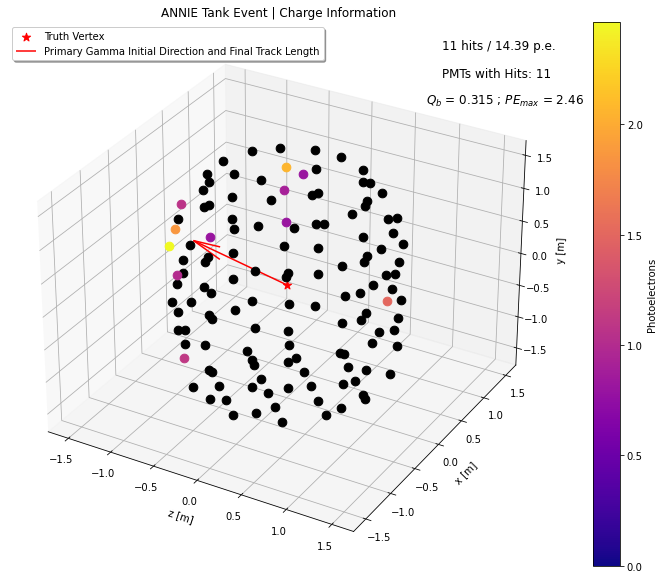

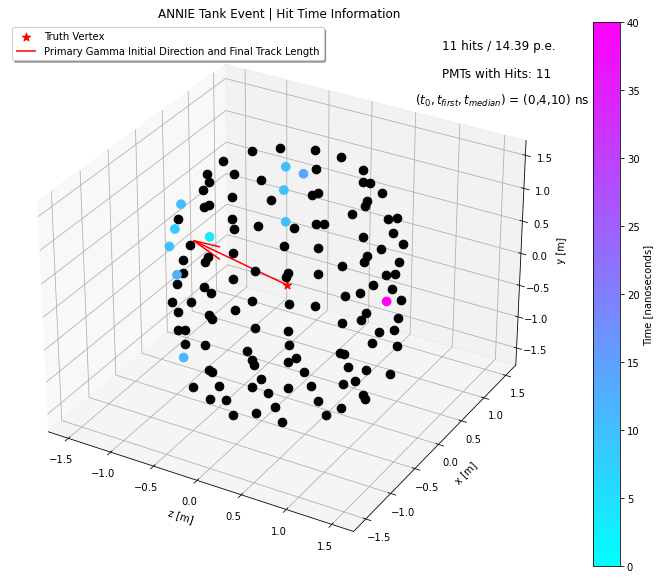


done


In [3]:
# Now that we have the charge, time, and hit information, we can construct the 3D event display

# # # # # # # # # # # # #
# Displaying Tank Event #
# # # # # # # # # # # # #

# Parameterization

How_many_events = 1    # How many events should be displayed/saved?  (setting it equal to N_events = all)

event_offset = 0       # Adjust to plot a later event

SavePlot = True       # Should the Plot be saved?

Name = '3D_Plots/ANNIE Simulated 3D Event'     # Name of the Plot/Event?

PMT_markersize = 75    # 75 is standard

#%matplotlib           # uncomment if you want to view in 3D (not advised for many windows/events)

################################################

from mpl_toolkits.mplot3d import Axes3D

print('###########################')

for i in range(How_many_events):
    
    i = i + event_offset
    
    print('\nDisplaying Event ' + str(int(clustereventNumber[i])))
    
    ##########################################################
    ###### Charge ######

    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(projection='3d', computed_zorder=False)   # zorder was not manual as of 3.5.0

    # Plot PMTs that were not hit  (assigned black)
    for cn in range(len(channel_number)):
        if channel_number[cn] not in unique_PMTs[i][0]:   # construct base geometry of PMTs not hit
            ax.scatter(z_position[cn], x_position[cn], y_position[cn], s = PMT_markersize, color = 'black', zorder = 5)

    for hit in range(len(Channel[i])):     # loop over hit PMTs
        index = unique_PMTs[i][0].index(Channel[i][hit])   # Use summed charge per PMT
        p = ax.scatter(hitZ[i][hit], hitX[i][hit], hitY[i][hit], c = Sum_PE[i][index], cmap=plt.cm.plasma,
                       s = PMT_markersize, vmin = 0, vmax = max(Sum_PE[i]), alpha = 1, zorder = 5)

    fig.colorbar(p, label = 'Photoelectrons')   # colorbar depecting the amount of charge recorded on each PMT
    
    # # # # # # # # # # # # # # # # #

    # Statistics
    hits_text = str(int(clusterHits[i])) + ' hits / ' + str(round(clusterPE[i],2)) + ' p.e.'
    ax.text2D(0.8,0.95,hits_text,size = 12,transform = ax.transAxes)
    PMT_text = 'PMTs with Hits: '+ str(len(unique_PMTs[i][0]))
    ax.text2D(0.8,0.90,PMT_text,size = 12,transform = ax.transAxes)
    
    chargebalance = r'$Q_{b}$' + ' = ' + str(round(clusterChargeBalance[i],3)) + ' ; ' + r'$PE_{max}$' + ' = ' + str(round(max(Sum_PE[i]),2))
    ax.text2D(0.77,0.85,chargebalance,size = 12,transform = ax.transAxes)
    
    
    
    # # # # # # # # # # # # # # # # #
    
    # Plot De-excitation position (truth) - figure is (z,x,y) but loaded origin is (x,y,z)
    ax.scatter(origin[i][0],origin[i][1],origin[i][2], s = PMT_markersize, color = 'red', marker = '*', zorder = 1, label = 'Truth Vertex')
    
    # Plot the de-excitation direction
    scale = Track_Length[i]   # Scale of arrow will be the real track length of the primary gamma
    ax.quiver(origin[i][0], origin[i][1], origin[i][2], dirZ[i]*scale, dirX[i]*scale, dirY[i]*scale, 
               color = 'red', label = 'Primary Gamma Initial Direction and Final Track Length', zorder = 1)
    
    # Important to note that the track length is simply the difference between the start and stop vertex. 
    # The initial direction is truth, but the actual direction as the gamma propagates may change. 
    # Therefore, the quiver within the plot is more of a visual representation of the shower.

    ax.set_aspect('auto')
    ax.set_xlabel('z [m]')
    ax.set_ylabel('x [m]')
    ax.set_zlabel('y [m]')

    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([max(z_position)-min(z_position), max(x_position)-min(x_position), max(y_position)-min(y_position)]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(max(z_position)+min(z_position))
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(max(x_position)+min(x_position))
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(max(y_position)+min(y_position))
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')

    plt.title('ANNIE Tank Event | Charge Information')
    plt.legend(shadow=True, loc = 'upper left')

    if SavePlot == True:
        path = Name + ' _ Charge Plot.png'
        plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
    
    plt.show()
    
    ##################################################################
    ###### Time ######
    
    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(projection='3d', computed_zorder=False)   # zorder was not manual as of 3.5.0

    # PMTs that were not hit
    for cn in range(len(channel_number)):
        if channel_number[cn] not in unique_PMTs[i][0]:   # construct base geometry of PMTs not hit
            ax.scatter(z_position[cn], x_position[cn], y_position[cn], s = PMT_markersize, color = 'black', zorder = 5)

    # We want to assign colors depicting the timing of each PMT hit
    # For now, there will be degeneracy where the same PMT is hit multiple times (the scatterpoints will overlay)
    # Could change this in the future to an average hit time - for now just keep the final hit time

    p = ax.scatter(hitZ[i], hitX[i], hitY[i], c = hitT[i], cmap=plt.cm.cool, vmin = t0[i], vmax = max(hitT[i]), 
                   s = PMT_markersize, alpha = 1, zorder = 5)
    
    fig.colorbar(p, label = 'Time [nanoseconds]')

    # # # # # # # # # # # # # # # # #

    # Statistics
    hits_text = str(int(clusterHits[i])) + ' hits / ' + str(round(clusterPE[i],2)) + ' p.e.'
    ax.text2D(0.8,0.95,hits_text,size = 12,transform = ax.transAxes)
    PMT_text = 'PMTs with Hits: '+ str(len(unique_PMTs[i][0]))
    ax.text2D(0.8,0.90,PMT_text,size = 12,transform = ax.transAxes)
    
    import statistics as st
    t_text = r'$(t_{0},t_{first},t_{median})$' + ' = (' + str(int(t0[i])) + ',' +  str(int(min(hitT[i]))) + ',' + str(int(st.median(hitT[i]))) + ') ns'
    ax.text2D(0.75,0.85,t_text,size = 12,transform = ax.transAxes)
    
    # # # # # # # # # # # # # # # # #

    # Plot De-excitation position (truth) - figure is (z,x,y) but loaded origin is (x,y,z)
    ax.scatter(origin[i][0],origin[i][1],origin[i][2], s = PMT_markersize, color = 'red', marker = '*', zorder = 1, label = 'Truth Vertex')
    
    # Plot the de-excitation direction
    scale = Track_Length[i]   # Scale of arrow will be the real track length of the primary gamma
    ax.quiver(origin[i][0], origin[i][1], origin[i][2], dirZ[i]*scale, dirX[i]*scale, dirY[i]*scale, 
               color = 'red', label = 'Primary Gamma Initial Direction and Final Track Length', zorder = 1)

    ax.set_aspect('auto')
    ax.set_xlabel('z [m]')
    ax.set_ylabel('x [m]')
    ax.set_zlabel('y [m]')

    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([max(z_position)-min(z_position), max(x_position)-min(x_position), max(y_position)-min(y_position)]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(max(z_position)+min(z_position))
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(max(x_position)+min(x_position))
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(max(y_position)+min(y_position))
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')

    plt.title('ANNIE Tank Event | Hit Time Information')
    plt.legend(shadow=True, loc = 'upper left')

    if SavePlot == True:
        path = Name + ' _ Timing Plot.png'
        plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

    plt.show()

###################################################

print('\ndone')

-----------------------
#### 2D event Display

In [4]:
# Now for the 2D Event Display

# This cell is for loading in the correct unfolded 2D geometry of the tank

# We have to unravel the PMT location from 3D (on a cylinder) to a 2D cutaway
# We will have two circles (top and bottom) + a rectangle (sides). 
# The top and bottom will be easy, as they have one dimension already fixed.

# # # # # # # # # # # # # # # # # # # #
# Split Barrel PMTs from Top/Bottom
barrel_index = []; Top_index = []; Bottom_index = []
for i in range(len(location)):
    if location[i] == 'Barrel':
        barrel_index.append(i)
    elif location[i] == 'Bottom':
        Bottom_index.append(i)
    elif location[i] == 'Top':
        Top_index.append(i)

# For the barrel PMTs, we can find the distance from the PMT to the 'Top' PMTs (in y) - this will serve as one
# of the dimensions in the 2D barrel plot. We can get the other dimension through an angle phi. 
# Relative to the centerpoint and some fixed point along the barrel, we can assume the PMT racks are cylindrical
# and calculate their angle WRT to some fixed PMT. From there we know the radius and can calculate an arclength.
# This arclength will end up being our other dimension (spacing between the PMTs).

# Take point (z = 0, x = min(x_position)) as the fixed reference point (phi = 0), as it is between two panels.
# The angle will be in the Z-X plane.

# use law of cosines to find the angle phi --> cos(phi) = (r^2 + a^2 + x^2)/(2ra)
# where:   r = distance between ref point and center, a = distance between PMT and center, x = distance between PMT and ref point
# Since the angle will run from [0,pi], we will have degeneracy - we can use the panel numbers to distinguish each side of the barrel.
# --> Based on the geometry of the tank, define PMTs on panels 3, 4, 5, 6 as being one set of angles ("right" side)
#     PMTs 2, 1, 8, 7 will be the other. We can then artifically add (-) to one set of PMT angles to get a full range [0,2pi]

ref_point = [0, min(x_position)]    # [z,x]
ref_radius = np.sqrt((ref_point[0]-0)**2 + (ref_point[1]-0)**2)

# find the "radius" of the Tank (avg distance from PMTs to centerpoint, in Z-X plane) (centerpoint is 0,0,0)
sum_radius = 0.
for i in range(len(channel_number)):
    if i in barrel_index:
        sum_radius = sum_radius + np.sqrt((x_position[i]**2) + (z_position[i]**2))
        
radius = sum_radius/len(barrel_index)              # this will be used to calculate the arclength once we have phi
                                                   # (assume all PMTs along the barrel share this avg radius (a good approx.))

left_panels = [1,2,7,8]                            # categorize which panels are "left" vs "right"

barrel_angles = [];
for i in range(len(channel_number)):
    if i in barrel_index:
        x = np.sqrt(((z_position[i] - ref_point[0])**2) + ((x_position[i] - ref_point[1])**2))
        a = np.sqrt((x_position[i]**2) + (z_position[i]**2))
        r = ref_radius
        cos_phi = ((r**2)+(a**2)-(x**2))/(2*r*a)   # law of cosines, solving for cos(phi)
        phi = np.arccos(cos_phi)                   # units of radians
            
        if panel_number[i] in left_panels:         # Break barrel into "left" and "right" PMTs
            barrel_angles.append(phi)              # given in radians, run from [0,pi]
        else:
            barrel_angles.append(-phi)             # run from [-0 to -pi]
    else:
        barrel_angles.append('Not Barrel')         # to keep the dimensionality consistent

# convert into a linear distance (arclength = r*phi) away from the ref PMT, for barrel PMTs
dist_barrel = []
for i in range(len(channel_number)):
    if i in barrel_index:
        s = barrel_angles[i]*radius
        dist_barrel.append(s)
    else:
        dist_barrel.append('Not Barrel')

# Do the other dimension (y)
# --> we can just use the actual y-positions of the PMTs
barrel_height = []
for i in range(len(channel_number)):
    if i in barrel_index:
        barrel_height.append(y_position[i])
    else:
        barrel_height.append('Not Barrel')

# Now we can do the Top and Bottom PMTs
# Both Top and Bottom will only have Z-X coordinates (all at the ~same y height)
Top_z = []; Top_x = []; Bottom_z = []; Bottom_x = []
for i in range(len(channel_number)):
    if i in Top_index:
        Top_z.append(z_position[i]); Top_x.append(x_position[i])
        Bottom_z.append('Not Bottom'); Bottom_x.append('Not Bottom')
    elif i in Bottom_index:
        Top_z.append('Not Top'); Top_x.append('Not Top')
        Bottom_z.append(z_position[i]); Bottom_x.append(x_position[i])
    else:
        Top_z.append('Not Top'); Top_x.append('Not Top')
        Bottom_z.append('Not Bottom'); Bottom_x.append('Not Bottom')
        

# # # # # # # # # # # # # # # # 
print('done')

done


###########################


<Figure size 720x720 with 0 Axes>

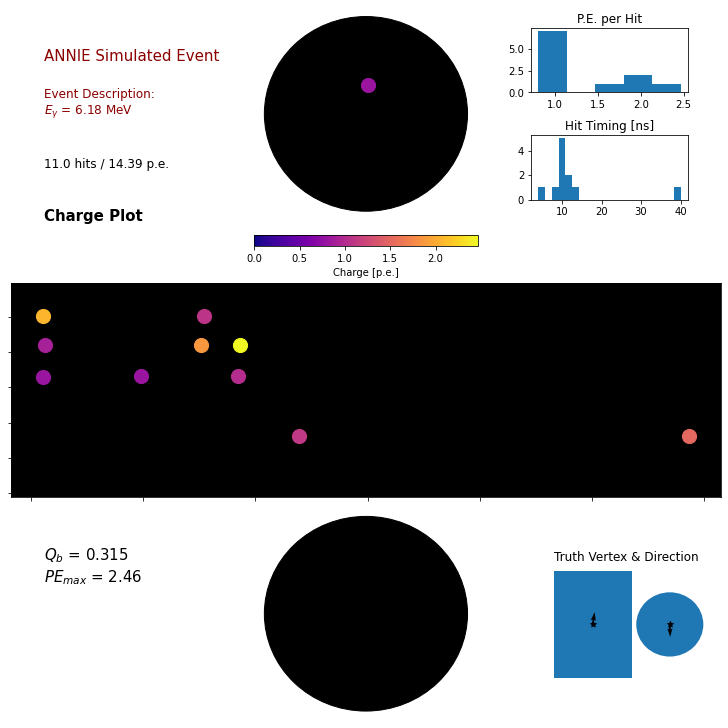

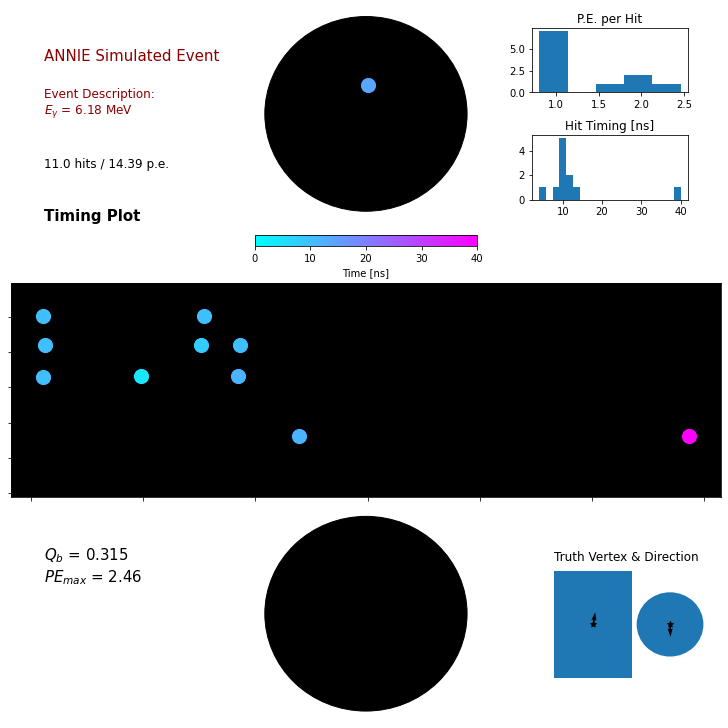


done


In [6]:
# # # # # # # # # # # # #
# Displaying Tank Event #
# # # # # # # # # # # # #

# Parameterization

How_many_events = 1    # How many events should be displayed/saved?  (setting it equal to N_events = all)

event_offset = 0       # Adjust to plot a later event (this is the starting event number you wish to plot)

SavePlot = True        # Should the Plot be saved?
Name = '2D_Plots/ANNIE Simulated Event 3'     # Name of the Plot/Event?

#%matplotlib            # View in external window (not advised for displaying multiple windows/events)

#####################################################################

from matplotlib.gridspec import GridSpec

print('###########################')

# # # # # # # # # # # # # # # # # # # # # # #
# Debugging:
# for some reason, if you run this cell on its own it fails to display due to a 
# float division by zero error in matplotlib. Seems to be a visualization error.
# To alleviate this, run these lines first:
fig = plt.figure(figsize = (10,10), constrained_layout=True)
plt.show()
# # # # # # # # # # # # 

# # # # # # # # # # # # # # # # #
# Build the Figure

def BuildEventDisplay2D(N_Hits,Total_Charge,En,Charge,Time,origin_x,origin_y,origin_z,DV_x,DV_y,DV_z,Qb,maxpe):

    ##########################################################
    def format_axes(fig):
        for i, ax in enumerate(fig.axes):
            ax.tick_params(labelbottom=False, labelleft=False)

    fig = plt.figure(figsize = (10,10), constrained_layout=True)
    gs = GridSpec(3, 3, figure=fig)
    ax_top = fig.add_subplot(gs[0, 1])
    ax_barrel = fig.add_subplot(gs[1, :])
    ax_bottom = fig.add_subplot(gs[2, 1])
    
    # subplot figure for text and title
    ax_text = fig.add_subplot(gs[0,0])
    ax_text.axis('off')
    # Add Statistics on PE's
    hits_text = str(N_Hits) + ' hits / ' + str(round(Total_Charge,2)) + ' p.e.'
    ax_text.text(0.15,0.25,hits_text,size = 12,transform = ax_text.transAxes)

    # Add a Description and Title
    title = 'ANNIE Simulated Event'
    description = 'Event Description: \n' + r'$E_{\gamma}$' + ' = ' + str(En) + ' MeV'
    ax_text.text(0.15, 0.75,title,size=15,color='darkred',transform=ax_text.transAxes)
    ax_text.text(0.15, 0.5,description,size=12,color='darkred',transform=ax_text.transAxes)

    #####################################################################################
    # Adding histograms displaying the charge and timing distributions of the given event
    ax_hist = fig.add_subplot(gs[0,2])
    ax_hist.axis('off')
    # # # # # # # # # #
    ax_charge = ax_hist.inset_axes([0.15, 0.6, 0.7, 0.3])
    ax_charge.set_title('P.E. per Hit')
    ax_charge.hist(Charge, bins = 'auto')   # allows matplotlib to chose between available options --> see documentation
    # # # # # # # # # #
    ax_time = ax_hist.inset_axes([0.15, 0.1, 0.7, 0.3])
    ax_time.set_title('Hit Timing [ns]')
    ax_time.hist(Time, bins = 'auto')
    ######################################################################################
    # add model of tank to indicate vertex position and direction of primary particle
    ax_tank = fig.add_subplot(gs[2,2])
    ax_tank.axis('off')
    circle_tank = plt.Circle((0.77,0.45), (.15))
    ax_tank.add_patch(circle_tank)
    rect_tank = plt.Rectangle((0.25,0.20), 0.35, 0.5)   # (x,y coords gives the corner of the rectangle)
    ax_tank.add_patch(rect_tank)
    
    # Position of the vertex
    scale = 0.15/radius
    # origin (z,x,y)
    z_psuedo = 0.77 + origin_z*scale; x_psuedo = 0.45 + origin_x*scale
    ax_tank.scatter(z_psuedo, x_psuedo, marker = '*', color = 'black')
    
    scale_z = 0.35/(radius*2); scale_y = 0.5/(3)  # height scaling
    z_psuedo_r = 0.25 + (0.35/2) + origin_z*scale_z; y_psuedo_r = 0.20 + (0.5/2) + origin_y*scale_y
    ax_tank.scatter(z_psuedo_r, y_psuedo_r, marker = '*', color = 'black')
    
    ver = 'Truth Vertex & Direction'
    ax_tank.text(0.25, 0.75,ver,size=12,color='black',transform=ax_tank.transAxes)
    
    ax_tank.set_xlim([0,1])
    ax_tank.set_ylim([0,1])
    
    # Direction of primary particle (direction_vector[x,y,z])
    ax_tank.quiver(z_psuedo, x_psuedo, DV_y, DV_z, color = 'black')#, scale_units='xy', scale = 12)  # arbitrary scaling
    ax_tank.quiver(z_psuedo_r, y_psuedo_r, DV_y, DV_x, color = 'black')#, scale_units='xy', scale = 2.5)
    ######################################################################################
    # Charge Balance and Max PE
    ax_qb = fig.add_subplot(gs[2,0])
    ax_qb.axis('off')
    
    chargebalance = r'$Q_{b}$' + ' = ' + str(round(Qb,3))
    ax_qb.text(0.15, 0.75,chargebalance,size=15,color='black',transform=ax_qb.transAxes)
    
    maximumpe = r'$PE_{max}$' + ' = ' + str(round(maxpe,2))
    ax_qb.text(0.15, 0.65,maximumpe,size=15,color='black',transform=ax_qb.transAxes)
    
    ######################################################################################
    format_axes(fig)   # remove tick markers

    # Draw top and bottom black circles --> these will serve as our subplots
    circle_top = plt.Circle((0,0), (1), color='black', zorder = 1)
    ax_top.add_patch(circle_top)

    circle_bottom = plt.Circle((0,0), (1), color='black', zorder = 1)
    ax_bottom.add_patch(circle_bottom)

    # Turn off Top and Bottom (and text) axes --> will replace top/bottom with black circles
    ax_bottom.axis('off')
    ax_top.axis('off')
    
    # Set the PMT barrel plot backgrounds black
    ax_barrel.set_facecolor('black')
    
    return ax_top, ax_barrel, ax_bottom, ax_text

#############################
# Plotting

PMT_marker_size = 200

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
############################ Charge Plot ##############################
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

for i in range(How_many_events):

    ax_top, ax_barrel, ax_bottom, ax_text = BuildEventDisplay2D(clusterHits[i],clusterPE[i],Energy[i],hitPE[i],hitT[i],
                                                               origin[i][1],origin[i][2],origin[i][0],dir_vector[i][1],
                                                                dir_vector[i][2],dir_vector[i][0],clusterChargeBalance[i],
                                                               clusterMaxPE[i])
    ax_text.text(0.15, 0.0,'Charge Plot',size=15,color='black',transform=ax_text.transAxes,fontweight = 'bold')

    # If the top or bottom are not hit, the plots do not scale correctly - add one black scatterpoint to scale correctly
    ax_top.scatter(Top_z[0], Top_x[0], s = PMT_marker_size, color = 'black')
    ax_bottom.scatter(Bottom_z[0], Bottom_x[0], s = PMT_marker_size, color = 'black')
    

    # For the Charge Plot, we will display the summed charge per PMT, since we may have multiple hits per PMT
    # Ensure the colorbar is scaled by the brightest PMT (take vmax = max(pmt_charge))
    for hit in range(len(Channel[i])):  # loop through hit PMTs
        index = unique_PMTs[i][0].index(Channel[i][hit])
        index_id = channel_number.index(Channel[i][hit])
        if Top_z[index_id] != 'Not Top':
            ax_top.scatter(Top_z[index_id], Top_x[index_id], s = PMT_marker_size, c = Sum_PE[i][index], cmap=plt.cm.plasma,
                           vmin = 0, vmax = max(Sum_PE[i]), alpha = 1)
            if hits_per_PMT[i][0][index] > 1:
                ax_top.annotate(hits_per_PMT[i][0][index], (Top_z[index_id]+0.06, Top_x[index_id]+0.06), color = 'white')
        if Bottom_z[index_id] != 'Not Bottom':
            ax_bottom.scatter(Bottom_z[index_id], Bottom_x[index_id], s = PMT_marker_size, c = Sum_PE[i][index], cmap=plt.cm.plasma,
                              vmin = 0, vmax = max(Sum_PE[i]), alpha = 1)
            if hits_per_PMT[i][0][index] > 1:
                ax_bottom.annotate(hits_per_PMT[i][0][index], (Bottom_z[index_id]+0.06, Bottom_x[index_id]+0.06), color = 'white')
        if dist_barrel[index_id] != 'Not Barrel':
            p = ax_barrel.scatter(dist_barrel[index_id],barrel_height[index_id], s = PMT_marker_size, c = Sum_PE[i][index],
                                  cmap=plt.cm.plasma, vmin = 0, vmax = max(Sum_PE[i]), alpha = 1)
            if hits_per_PMT[i][0][index] > 1:
                ax_barrel.annotate(hits_per_PMT[i][0][index], (dist_barrel[index_id]+0.07, barrel_height[index_id]+0.07), color = 'white')

    # Set barrel plot y-limits to the height of the top and bottom PMT rack
    ax_barrel.set_ylim([min(y_position),max(y_position)])

    # set colorbar
    fig.colorbar(p, ax=ax_top, label = 'Charge [p.e.]', location = 'bottom')

    if SavePlot == True:
        path = Name + ' _ Charge Plot.png'
        plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
    
    plt.show()


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
############################ Timing Plot ##############################
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

for i in range(How_many_events):

    ax_top, ax_barrel, ax_bottom, ax_text = BuildEventDisplay2D(clusterHits[i],clusterPE[i],Energy[i],hitPE[i],hitT[i],
                                                               origin[i][1],origin[i][2],origin[i][0],dir_vector[i][1],
                                                                dir_vector[i][2],dir_vector[i][0],clusterChargeBalance[i],
                                                               clusterMaxPE[i])
    ax_text.text(0.15, 0.0,'Timing Plot',size=15,color='black',transform=ax_text.transAxes,fontweight = 'bold')

    # If the top or bottom are not hit, the plots do not scale correctly - add one black scatterpoint to scale correctly
    ax_top.scatter(Top_z[0], Top_x[0], s = PMT_marker_size, color = 'black')
    ax_bottom.scatter(Bottom_z[0], Bottom_x[0], s = PMT_marker_size, color = 'black')
    

    # Timing Plot
    for hit in range(len(Channel[i])):  # loop through hit PMTs
        index = unique_PMTs[i][0].index(Channel[i][hit])
        index_id = channel_number.index(Channel[i][hit])
        if Top_z[index_id] != 'Not Top':
            ax_top.scatter(Top_z[index_id], Top_x[index_id], s = PMT_marker_size, c = hitT[i][hit], cmap=plt.cm.cool,
                           vmin = 0, vmax = max(hitT[i]), alpha = 1)
            if hits_per_PMT[i][0][index] > 1:
                ax_top.annotate(hits_per_PMT[i][0][index], (Top_z[index_id]+0.06, Top_x[index_id]+0.06), color = 'white')
        if Bottom_z[index_id] != 'Not Bottom':
            ax_bottom.scatter(Bottom_z[index_id], Bottom_x[index_id], s = PMT_marker_size, c = hitT[i][hit], cmap=plt.cm.cool,
                              vmin = 0, vmax = max(hitT[i]), alpha = 1)
            if hits_per_PMT[i][0][index] > 1:
                ax_bottom.annotate(hits_per_PMT[i][0][index], (Bottom_z[index_id]+0.06, Bottom_x[index_id]+0.06), color = 'white')
        if dist_barrel[index_id] != 'Not Barrel':
            p = ax_barrel.scatter(dist_barrel[index_id],barrel_height[index_id], s = PMT_marker_size, c = hitT[i][hit],
                                  cmap=plt.cm.cool, vmin = 0, vmax = max(hitT[i]), alpha = 1)
            if hits_per_PMT[i][0][index] > 1:
                ax_barrel.annotate(hits_per_PMT[i][0][index], (dist_barrel[index_id]+0.07, barrel_height[index_id]+0.07), color = 'white')

    # Set barrel plot y-limits to the height of the top and bottom PMT rack
    ax_barrel.set_ylim([min(y_position),max(y_position)])

    # set colorbar
    fig.colorbar(p, ax=ax_top, label = 'Time [ns]', location = 'bottom')

    if SavePlot == True:
        path = Name + ' _ Timing Plot.png'
        plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
    
    plt.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#######################################################################

print('\ndone')  

--------------------------------------------------------------------------------